In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/IoB power consumption/household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [ ]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
df.count()

Global_active_power      2049280
Global_reactive_power    2049280
Voltage                  2049280
Global_intensity         2049280
Sub_metering_1           2049280
Sub_metering_2           2049280
Sub_metering_3           2049280
dtype: int64

In [ ]:
values = df.values.astype('float32')
df['sub_metering_4'] = (values[:,0] * 1000 / 60) - (values[:,4] + values[:,5] + values[:,6])
df['ds']=df.index
df["day_name"]= df['ds'].dt.day_name()

In [ ]:
df.drop(['ds'], axis=1, inplace=True)

In [ ]:
df.head() 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_name
dt,,,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,52.266670,Saturday
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,72.333336,Saturday
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,70.566666,Saturday
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,71.800003,Saturday
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,43.099998,Saturday


In [ ]:
droping_list_all=[]
for j in range(0,9):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
droping_list_all

[0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
sub_metering_4           25979
day_name                     0
dtype: int64

In [ ]:
for j in range(0,8):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

In [ ]:
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
sub_metering_4           0
day_name                 0
dtype: int64

In [ ]:
df.count()

Global_active_power      2075259
Global_reactive_power    2075259
Voltage                  2075259
Global_intensity         2075259
Sub_metering_1           2075259
Sub_metering_2           2075259
Sub_metering_3           2075259
sub_metering_4           2075259
day_name                 2075259
dtype: int64

In [ ]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
count,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06,2.075259e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00,9.317223e+00
std,1.050655e+00,1.120142e-01,3.219643e+00,4.416490e+00,6.114397e+00,5.785470e+00,8.384178e+00,9.519520e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00,-2.400000e+00
25%,3.100000e-01,4.800000e-02,2.390200e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.833333e+00
50%,6.300000e-01,1.020000e-01,2.409600e+02,2.800000e+00,0.000000e+00,0.000000e+00,1.000000e+00,5.566667e+00
75%,1.520000e+00,1.920000e-01,2.428600e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01,1.023333e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01,1.248333e+02


# LSTM

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
df_resample = df.resample('h').sum() 
df_resample.shape

(34589, 8)

In [ ]:
df_resample.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
dt,,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0,1907.733398
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0,2217.199951
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0,2313.233398
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0,2261.566650
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0,1998.466675


In [ ]:
df_resample.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4
count,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000,34589.000000
mean,65.494346,7.422579,14449.827483,277.654721,67.312771,77.908157,387.491717,558.854004
std,53.511436,3.983965,196.201130,224.019459,210.958049,250.001386,438.232263,493.144379
min,2.804000,0.000000,719.070000,11.400000,0.000000,0.000000,0.000000,46.733334
25%,20.618000,4.700000,14352.740000,91.200000,0.000000,0.000000,39.000000,262.133331
50%,49.296000,6.468000,14456.120000,210.000000,0.000000,20.000000,100.000000,349.333344
75%,94.212000,8.922000,14560.420000,393.800000,0.000000,40.000000,837.000000,658.433350
max,393.632000,46.460000,15114.120000,1703.000000,2902.000000,2786.000000,1293.000000,3890.233398


In [ ]:
df_resample["day_name"]= df_resample.index.day_name()
df_resample.head(2)

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_name
dt,,,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0,1907.733398,Saturday
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0,2217.199951,Saturday


In [ ]:
from sklearn.preprocessing import MinMaxScaler

values = df_resample.values 

# frame as supervised learning
reframed1 = series_to_supervised(df_resample, 1, 1)

# drop columns we don't want to predict
reframed2= reframed1.drop(reframed1.columns[[7,8,9,10,11,12,14,15,16,17]], axis=1)
reframed2.head()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed2.values)
reframed = pd.DataFrame(scaled, columns=  ["var1(t-1)","var2(t-1)","var3(t-1)","var4(t-1)","var5(t-1)"	,"var6(t-1)","var7(t-1)","var5(t)"])
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var5(t)
0,0.374384,0.163471,0.000000,0.371473,0.0,0.006820,0.469451,0.0
1,0.545045,0.088127,0.844110,0.541487,0.0,0.144652,0.782676,0.0
2,0.509006,0.094957,0.831981,0.502152,0.0,0.030869,0.774169,0.0
3,0.488550,0.081648,0.839532,0.481110,0.0,0.000000,0.778809,0.0
4,0.455597,0.083705,0.867315,0.449904,0.0,0.008973,0.798917,0.0


In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 365*3*24
train = values[:n_train_time, :]
test = values[n_train_time:, :]
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(26280, 1, 7) (26280,) (8308, 1, 7) (8308,)


In [ ]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/20
822/822 - 4s - loss: 0.0046 - val_loss: 0.0037
Epoch 2/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 3/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 4/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 5/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 6/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 7/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 8/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 9/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 10/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 11/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 12/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 13/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 14/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 15/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 16/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 17/20
822/822 - 2s - loss: 0.0045 - val_loss: 0.0036
Epoch 

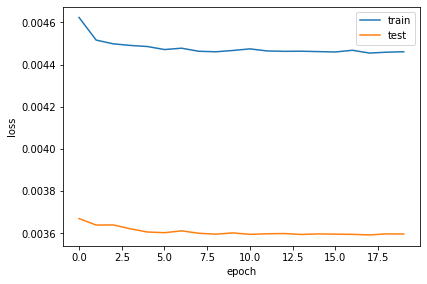

In [ ]:
import matplotlib.pyplot as plt
from pylab import rcParams

rcParams['figure.figsize'] =[6.4, 4.4]

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.savefig("IOB_loss_Sub_metering_1.pdf", bbox_inches='tight')

plt.show()



In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.metrics import mean_absolute_error

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat = np.concatenate((test_X[:, -7:],yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_X[:, -7:],test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
mae = mean_absolute_error(inv_y, inv_yhat)
print('Test RMSE: %.3f' % rmse)
print('Test MAE: %.3f' % mae)

Test RMSE: 174.003
Test MAE: 78.078


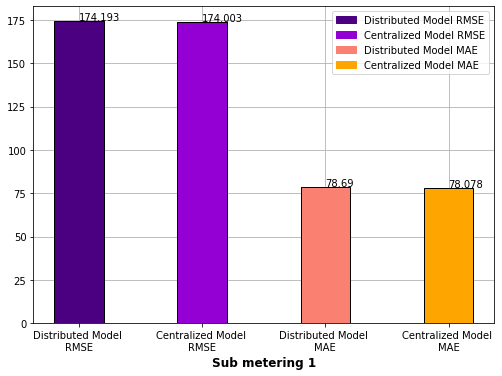

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.patches as mpatches

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Distributed Model \nRMSE', 'Centralized Model \nRMSE', 'Distributed Model \nMAE','Centralized Model \nMAE']
y = [174.193,174.003 ,78.690, 78.078]

#plt.plot(x, y, '-o', color='orange')
ax.bar(x,y, color=['indigo','darkviolet','salmon','orange'],  width=0.4, edgecolor="black", zorder=3)
plt.xlabel('Sub metering 1', fontweight="bold",size=12)
#plt.ylabel('', fontweight="bold")
rcParams.update({'figure.autolayout': True})
plt.xticks(rotation=0)
plt.grid(zorder=0)
L = [mpatches.Patch(color=c, label=col)  for col,c in zip(['Distributed Model RMSE', 'Centralized Model RMSE', 'Distributed Model MAE','Centralized Model MAE'], ['indigo','darkviolet','salmon','orange'])]
for index,data in enumerate(y):
    plt.text(x=index , y =data+0.5, s=f"{data}" , fontdict=dict(fontsize=10), color="black")

plt.legend(handles=L, loc=1)
plt.savefig('Sub_metering_1 error.pdf', format='pdf', bbox_inches = "tight")

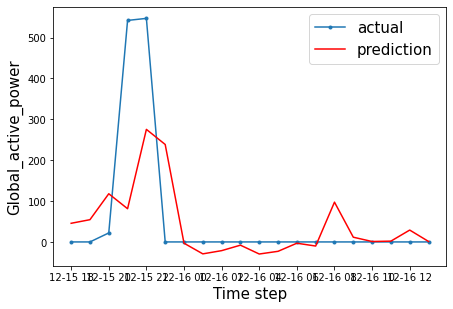

In [ ]:

aa=[x for x in range(20)]
plt.plot(reframed1[n_train_time:n_train_time+20].index, inv_y[:20], marker='.', label="actual")
plt.plot(reframed1[n_train_time:n_train_time+20].index, inv_yhat[:20], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
for_pred = reframed1[n_train_time:n_train_time+500]["var9(t)"].copy().reset_index()
for_pred['Dates'] = pd.to_datetime(for_pred.dt).dt.date
for_pred['Time'] = pd.to_datetime(for_pred.dt).dt.time

for_pred['yhat']= inv_yhat[:500]
for_pred

,dt,var9(t),Dates,Time,yhat
0,2009-12-15 18:00:00,Tuesday,2009-12-15,18:00:00,45.626350
1,2009-12-15 19:00:00,Tuesday,2009-12-15,19:00:00,54.445270
2,2009-12-15 20:00:00,Tuesday,2009-12-15,20:00:00,117.891638
3,2009-12-15 21:00:00,Tuesday,2009-12-15,21:00:00,81.271797
4,2009-12-15 22:00:00,Tuesday,2009-12-15,22:00:00,275.409954
...,...,...,...,...,...
495,2010-01-05 09:00:00,Tuesday,2010-01-05,09:00:00,256.391694
496,2010-01-05 10:00:00,Tuesday,2010-01-05,10:00:00,270.767843
497,2010-01-05 11:00:00,Tuesday,2010-01-05,11:00:00,11.195867
498,2010-01-05 12:00:00,Tuesday,2010-01-05,12:00:00,21.704979


In [ ]:
df_resample['Dates'] = pd.to_datetime(df_resample.index).date
df_resample['Time'] = pd.to_datetime(df_resample.index).time
df_resample

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,sub_metering_4,day_name,Dates,Time
dt,,,,,,,,,,,
2006-12-16 17:00:00,152.024,8.244,8447.18,651.6,0.0,19.0,607.0,1907.733398,Saturday,2006-12-16,17:00:00
2006-12-16 18:00:00,217.932,4.802,14074.81,936.0,0.0,403.0,1012.0,2217.199951,Saturday,2006-12-16,18:00:00
2006-12-16 19:00:00,204.014,5.114,13993.95,870.2,0.0,86.0,1001.0,2313.233398,Saturday,2006-12-16,19:00:00
2006-12-16 20:00:00,196.114,4.506,14044.29,835.0,0.0,0.0,1007.0,2261.566650,Saturday,2006-12-16,20:00:00
2006-12-16 21:00:00,183.388,4.600,14229.52,782.8,0.0,25.0,1033.0,1998.466675,Saturday,2006-12-16,21:00:00
...,...,...,...,...,...,...,...,...,...,...,...
2010-11-26 17:00:00,103.554,3.684,14224.18,433.0,0.0,0.0,772.0,953.899963,Friday,2010-11-26,17:00:00
2010-11-26 18:00:00,94.408,3.222,14251.91,397.2,0.0,0.0,0.0,1573.466675,Friday,2010-11-26,18:00:00
2010-11-26 19:00:00,99.560,3.602,14204.46,423.4,0.0,4.0,0.0,1655.333374,Friday,2010-11-26,19:00:00


In [ ]:
def fun(x):
  return df_resample[(df_resample.index.hour == x[0].hour) & (df_resample.index.month == x[0].month) & (df_resample['day_name']==x[1])].Sub_metering_1.mean() #+ 33.006

for_pred['hour_avg']=for_pred[['dt','var9(t)']].apply(fun,  axis=1)
for_pred

,dt,var9(t),Dates,Time,yhat,hour_avg
0,2009-12-15 18:00:00,Tuesday,2009-12-15,18:00:00,45.626350,0.000000
1,2009-12-15 19:00:00,Tuesday,2009-12-15,19:00:00,54.445270,53.625000
2,2009-12-15 20:00:00,Tuesday,2009-12-15,20:00:00,117.891638,126.687500
3,2009-12-15 21:00:00,Tuesday,2009-12-15,21:00:00,81.271797,166.937500
4,2009-12-15 22:00:00,Tuesday,2009-12-15,22:00:00,275.409954,109.937500
...,...,...,...,...,...,...
495,2010-01-05 09:00:00,Tuesday,2010-01-05,09:00:00,256.391694,155.888889
496,2010-01-05 10:00:00,Tuesday,2010-01-05,10:00:00,270.767843,0.000000
497,2010-01-05 11:00:00,Tuesday,2010-01-05,11:00:00,11.195867,33.500000
498,2010-01-05 12:00:00,Tuesday,2010-01-05,12:00:00,21.704979,244.666667


In [ ]:
for_pred[for_pred['yhat']>for_pred['hour_avg']].count()

dt          169
var9(t)     169
Dates       169
Time        169
yhat        169
hour_avg    169
dtype: int64

In [ ]:
warning = for_pred[for_pred['yhat']>for_pred['hour_avg']].copy()
warning['difference']= warning.yhat - warning.hour_avg
warning.head()

,dt,var9(t),Dates,Time,yhat,hour_avg,difference
0,2009-12-15 18:00:00,Tuesday,2009-12-15,18:00:00,45.626350,0.0000,45.626350
1,2009-12-15 19:00:00,Tuesday,2009-12-15,19:00:00,54.445270,53.6250,0.820270
4,2009-12-15 22:00:00,Tuesday,2009-12-15,22:00:00,275.409954,109.9375,165.472454
5,2009-12-15 23:00:00,Tuesday,2009-12-15,23:00:00,238.465195,43.0625,195.402695
22,2009-12-16 16:00:00,Wednesday,2009-12-16,16:00:00,57.049346,2.0625,54.986846


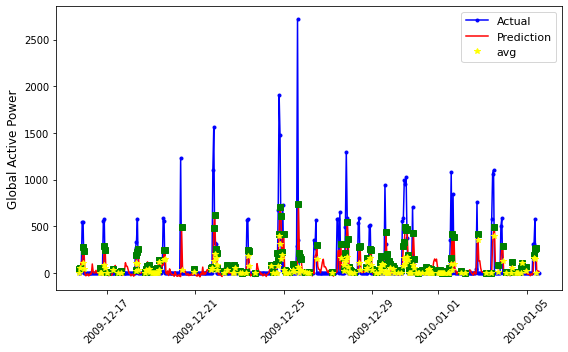

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] =8, 5

aa=[x for x in range(500)]
plt.plot(reframed1[n_train_time:n_train_time+500].index, inv_y[:500], marker='.',color='b', label="Actual")
plt.plot(reframed1[n_train_time:n_train_time+500].index, inv_yhat[:500], color='red', label="Prediction")
plt.plot(warning.dt, warning.yhat,'s',color='green')
plt.plot(warning.dt, warning.hour_avg,'*',color='yellow', label="avg")

plt.xticks(rotation=45)

plt.ylabel('Global Active Power', size=12)
#plt.xlabel('Time step', size=15)
plt.legend(fontsize=11)
plt.savefig("actual_vs_prediction.pdf", bbox_inches='tight')
plt.show()

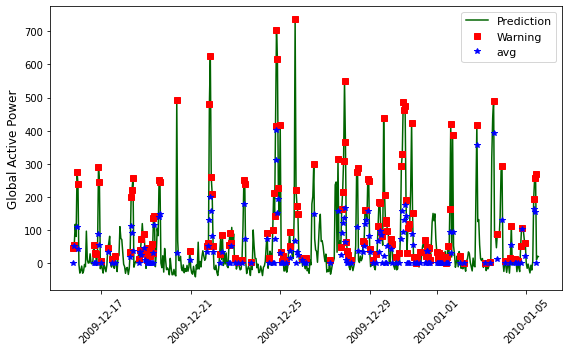

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] =8, 5

aa=[x for x in range(500)]
#plt.plot(reframed1[n_train_time:n_train_time+200].index, inv_y[:500], marker='.',color='b', label="actual")
plt.plot(reframed1[n_train_time:n_train_time+500].index, inv_yhat[:500], color='darkgreen', label="Prediction")
plt.plot(warning.dt, warning.yhat,'s',color='red', label="Warning")
plt.plot(warning.dt, warning.hour_avg,'*',color='blue', label="avg")

plt.xticks(rotation=45)

plt.show()

In [ ]:
warning.difference.sum()

15388.794363872083